## Liberaries

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import re
import datetime
from datetime import datetime
from datetime import date, timedelta
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
#import spacy
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords


from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from random import sample


import tensorflow as tf
import keras
from keras.datasets import imdb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from keras.layers import Dense

Using TensorFlow backend.


## Functions

In [2]:
def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

## Import Data

In [3]:
df_raw = pd.read_csv(r'E:\Data\Canmet\ML\pipeline\crude.csv', encoding = "ISO-8859-1")
df = df_raw.drop([ 'shut_explain', 'mat_details'], axis = 1)

In [11]:
len(df['name'].unique())

199

## Rename child companies

In [4]:
companies = [ 'williams ','western refining','vintage ', 'valero','unocal ','union oil','ugi ','torrance ','tesoro' ,'teppco ','targa ','sunoco ','shell ','public service ','plains ','phillips ','peoples ','oryx ','oneok ','nustar ','northern states power','national fuel','mustang ','mobil ','midcoast ','mid-continent','mid - valley', 'markwest ', 'marathon ', 'magellan','lone star', 'liberty ', 'genesis ', 'harvest', 'ldh energy', 'kinetica ', 'koch ', 'keyspan ', 'kinder morgan', 'interstate ', 'gulf ', 'great lakes', 'enable gas ', 'exxonmobil ', 'equistar ', 'express ', 'entergy ', 'energy xxi', 'enron ', 'enlink ', 'enbridge ', 'dow pipeline','duke energy', 'consumers ''alliant energy', 'bridger ', 'dominion energy', 'denbury ', 'corning ', 'delek ', 'chesapeake ', 'consolidated edison', 'centerpoint energy', 'columbia gas ', 'chevron ', 'conocophillips ', 'buckeye ', 'citgo ', 'colonial ', 'citizens ', 'bridgeline ', 'american midstream', 'amoco ', 'aquila ', 'atmos energy', 'avista ', 'boardwalk ', 'bp ', 'bridgeline ']
#reduces number of companies from 920 to 600
df['name'] = df['name'].apply(lambda x: x.lower() if type(x)== str else x)

for word in companies:
    df['name'] =  df['name'].apply(lambda x: word if type(x)==str and word in x else x)
#df = df.fillna(method='ffill')
df = df.fillna('nan')
df

,name,type,subtype,shut,state,area,area_sub,pipe_type,system,system_sub,item,material,release,function_pipe,op_type,cause,cause_sub,nlp
0,"bkep pipeline, llc",CRUDE OIL,nan,NO,OK,"TANK, INCLUDING ATTACHED APPURTENANCES",nan,INTRASTATE,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",ATMOSPHERIC OR LOW PRESSURE,VALVE,CARBON STEEL,OTHER,=< 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,CONTRACTOR WORKING FOR THE OPERATOR,INCORRECT OPERATION,"VALVE LEFT OR PLACED IN WRONG POSITION, BUT NO...",ACTION ENVIRONMENTAL WAS ON SITE TO CONDUCT RO...
1,kinder morgan,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,"DIESEL, FUEL OIL, KEROSENE, JET FUEL",NO,TX,ABOVEGROUND,TYPICAL ABOVEGROUND FACILITY PIPING OR APPURTE...,INTRASTATE,ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,nan,OTHER,CARBON STEEL,LEAK,=< 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,OPERATOR EMPLOYEE,EQUIPMENT FAILURE,THREADED CONNECTION/COUPLING FAILURE,ON 12/04/19 ON OPERATOR FOUND PRODUCT COMING F...
2,colonial,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,GASOLINE (NON-ETHANOL),NO,TX,"TANK, INCLUDING ATTACHED APPURTENANCES",nan,INTERSTATE,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",ATMOSPHERIC OR LOW PRESSURE,TANK/VESSEL,CARBON STEEL,LEAK,> 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,OPERATOR EMPLOYEE,EQUIPMENT FAILURE,"FAILURE OF EQUIPMENT BODY (EXCEPT PUMP), TANK ...","ON DECEMBER 4, 2019, A COLONIAL OPERATOR NOTED..."
3,"sfpp, lp",REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,"DIESEL, FUEL OIL, KEROSENE, JET FUEL",YES,CA,UNDERGROUND,UNDER SOIL,INTERSTATE,ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,nan,VALVE,CARBON STEEL,LEAK,> 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,OPERATOR EMPLOYEE,OTHER INCIDENT CAUSE,UNKNOWN,THE STATION OPERATOR DISCOVERED A LEAK ON THE ...
4,shell,CRUDE OIL,nan,NO,CA,UNDERGROUND,UNDER SOIL,INTRASTATE,"ONSHORE PIPELINE, INCLUDING VALVE SITES",nan,PIPE,CARBON STEEL,RUPTURE,=< 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,OPERATOR EMPLOYEE,CORROSION FAILURE,EXTERNAL CORROSION,LOPC 8M68 PURGING LINE LEAKS:CREWS WERE IN THE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3973,plains,CRUDE OIL,nan,NO,TX,UNDERGROUND,EXPOSED DUE TO EXCAVATION,INTERSTATE,"ONSHORE PIPELINE, INCLUDING VALVE SITES",nan,PIPE,CARBON STEEL,MECHANICAL PUNCTURE,> 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,nan,EXCAVATION DAMAGE,EXCAVATION DAMAGE BY THIRD PARTY,"ON JANUARY 7, 2010 AT APPROXIMATELY 1300 HOURS..."
3974,enbridge,CRUDE OIL,nan,nan,WI,UNDERGROUND,UNDER SOIL,INTERSTATE,ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,nan,VALVE,nan,LEAK,> 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,nan,NATURAL FORCE DAMAGE,TEMPERATURE,"ON JANUARY 6, 2010 AT APPROXIMATELY 19:30 LOCA..."
3975,"petrologistics olefins, llc",HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,OTHER HVL,nan,LA,ABOVEGROUND,OTHER,INTRASTATE,ONSHORE PUMP/METER STATION EQUIPMENT AND PIPING,nan,TUBING,MATERIAL OTHER THAN CARBON STEEL,LEAK,> 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,nan,EQUIPMENT FAILURE,DEFECTIVE OR LOOSE TUBING OR FITTING,ON TUESDAY JANUARY 5 2010 AT 10:30 AM WHILE FL...
3976,portland pipeline corp,CRUDE OIL,nan,nan,ME,ABOVEGROUND,TYPICAL ABOVEGROUND FACILITY PIPING OR APPURTE...,INTERSTATE,ONSHORE PUMP/METER STATION EQUIPMENT AND PIPING,nan,AUXILIARY PIPING (E.G. DRAIN LINES),nan,OTHER,> 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,nan,EQUIPMENT FAILURE,PUMP OR PUMP-RELATED EQUIPMENT,APPROXIMATELY 5 GALLONS OF CRUDE OIL OVERFLOWE...


## NLP

In [7]:
text = list(df['nlp'])
one_text = " ".join(text)
tkn = word_tokenize(one_text)
print("Number of all words: ", len(tkn))
print("Number of unique words: ", len(np.unique(np.hstack(tkn))))

txt = []
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
text_ = [re.sub('\d', ' ', x) for x in text]
for i in range(len(text)):
    temp = text_[i]
    temp = temp.strip().lower()
    cleaned = re.sub('\W+', ' ', temp)
    tokenized = word_tokenize(cleaned)
    filtered = [word for word in tokenized if word not in stop_words]
    #filtered_En = [word for word in filtered if word in words]
    lemmatized = [lemmatizer.lemmatize(token) for token in filtered]
    #freq = [word for word in lemmatized if dic[word]>9]
    string = TreebankWordDetokenizer().detokenize(lemmatized)
    txt.append(string)
    
name = list(df.name)
notes = []
for i in range(len(txt)):
    name_tokens = word_tokenize(name[i])
    review_tokens = word_tokenize(txt[i])
    note = [word for word in review_tokens if word not in name_tokens]
    string = TreebankWordDetokenizer().detokenize(note)
    notes.append(string)   
print('all reviews', len(notes))

one_text = " ".join(notes)
tkn = word_tokenize(one_text)
print("Number of all words after cleaning: ", len(tkn))
print("Number of unique words after cleaning: ", len(np.unique(np.hstack(tkn))))

Number of all words:  630496
Number of unique words:  20682
all reviews 3978
Number of all words after cleaning:  317460
Number of unique words after cleaning:  10113


### How it changes reviews:

In [10]:
i = 2
print(notes[i], '\n', '\n', text[i])

december operator noted tank might experiencing leak tank floor product migrating towards vicinity chine bottom extension chine bottom extension flat steel perimeter floor plate extends shell outside tank resting concrete ringwall foundation upon investigation gasoline leak confirmed central time determined gasoline seeping tank product contained within tank dike additionally containment boom placed within dike area december central time telephonic nrc report nrc made estimated quantity bbl released nrc report made due determination estimated cost associated release would exceed december central time telephonic hour nrc update nrc provided update following information tank emptied product december central time taken service oos thereby eliminating leak source change reported regard estimated release quantity bbl conducting incident analysis ia determine cause failure personnel evaluating appropriate inspection methodology investigating tank floor tank interior tank remains oos time env

In [42]:
y = np.asarray(df[['name']])
y = y.reshape(len(y),)
label_encoder = LabelEncoder()
feature = label_encoder.fit_transform(y)
feature = feature.reshape(len(feature), 1)
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
encoded_y = onehot_encoder.fit_transform(feature)
np.shape(encoded_y)

(3978, 199)

## Adding/OHE Features 

In [46]:
dfk = df
dfk = df.drop(['name', 'nlp'], axis = 1)
#dfk['cnt']=df.groupby('name')['Date'].transform('count')
#dfk = dfk.drop(dfk[dfk.cnt<10].index)
#dfk.reset_index(drop=True, inplace=True)#.head(50)
#dfk['day'] = df.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%a'))
#dfk['month'] = df.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%b'))
x = np.asarray(dfk)
y = np.asarray(df[['name']])
y = y.reshape(len(y),)

encoded_x = None
for i in range(0, x.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(x[:,i])
    feature = feature.reshape(x.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    feature = onehot_encoder.fit_transform(feature)
    if encoded_x is None:
        encoded_x = feature
    else:
            encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("X shape: : ", encoded_x.shape)
#state:53+day:7+m:12+name:689+system:6 : 767
#y = y.reshape(-1,1)
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
encoded_y = label_encoder.transform(y)
print("y shape: : ", encoded_y.shape)

X shape: :  (3978, 128)
y shape: :  (3978,)


In [47]:
vectorizer = CountVectorizer()
vectorizer.fit(notes)
#print(vectorizer.vocabulary_)
vector = vectorizer.transform(notes)
print(vector.shape)
print(type(vector))
print(vector.toarray())


(3978, 10087)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [50]:
vectorizer = TfidfVectorizer()
vectorizer.fit(txt)
vector = vectorizer.transform(txt)
print(vector.shape)
print(type(vector))
print(vector.toarray())

(3978, 10133)
<class 'scipy.sparse.csr.csr_matrix'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [35]:
y_train[125]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [51]:
test_size = 0.45
seed = 44
x_train, x_test, y_train, y_test = train_test_split(vector, encoded_y, test_size=test_size, random_state=seed)
units = 10
epochs = 2
batch_size = 128
lr = 0.01

model = Sequential()
model.add(Dense(units = units,input_dim = 128, activation='relu'))
model.add(Dense(units = units, activation='relu'))
model.add(Dense(units = 199,  activation='softmax'))
#model.compile(loss = 'mse',  optimizer = "adam")
opt = SGD(lr=lr, momentum=0.9, decay=0.001)
model.compile(optimizer = opt, loss='binary_crossentropy' ,  metrics=['accuracy'])
model.summary()
model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(x_test, y_test), verbose = 1, shuffle=True)

scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_35 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_36 (Dense)             (None, 199)               2189      
Total params: 3,589
Trainable params: 3,589
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking input: expected dense_34_input to have shape (128,) but got array with shape (10133,)

In [40]:
prediction_train = model.predict(x_train)
prediction_test = model.predict(x_test)
prediction_test[30]

array([0.0050217 , 0.00501397, 0.00500659, 0.00500978, 0.00501957,
       0.00505662, 0.00503077, 0.00502193, 0.00504521, 0.00502237,
       0.00504269, 0.00504237, 0.0050243 , 0.00502259, 0.00503151,
       0.00500156, 0.00504082, 0.00502217, 0.00502063, 0.00501647,
       0.00503429, 0.00504498, 0.00501174, 0.00504236, 0.00501944,
       0.00500984, 0.00501885, 0.00501515, 0.00501379, 0.00500791,
       0.00502849, 0.00504396, 0.00503104, 0.0050264 , 0.00502641,
       0.00502697, 0.00501464, 0.00503381, 0.00504342, 0.00504251,
       0.00502885, 0.00503971, 0.00503466, 0.00500235, 0.0050349 ,
       0.00502506, 0.00502125, 0.00502441, 0.0050285 , 0.00502173,
       0.00501451, 0.0050496 , 0.00502795, 0.00503934, 0.00501089,
       0.00502511, 0.0050131 , 0.00503942, 0.00503046, 0.00500073,
       0.00501101, 0.00501574, 0.00503283, 0.00501007, 0.00501914,
       0.00502428, 0.0050299 , 0.00503005, 0.00503264, 0.00503764,
       0.00500992, 0.00502191, 0.00504215, 0.00500043, 0.00502

## Random Forest

In [61]:
test_size = 0.25
seed = 44
x_train, x_test, y_train, y_test = train_test_split(encoded_x, encoded_y, test_size=test_size, random_state=seed)
n_estimators, max_depths, min_samples_split, min_samples_leaf = [150], [60], [5], [4]

for estimators in n_estimators:   
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                start_time = time.time()
                model = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, random_state = 413)
                model.fit(x_train, y_train)  
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                print(round(time.time() - start_time,2), accuracy_score(y_train, prediction_train),
        accuracy_score(y_test, prediction_test),estimators, max_depth, min_sample_split,min_sample_leaf)
                
edu_guess = np.asarray(sample(list(encoded_y),len(y_test)))
edu_guess = edu_guess.reshape(len(y_test),)
print('edu_guess:', accuracy_score(y_test, edu_guess))
#2.3 0.562185719074757 0.4020100502512563 150 60 5 4 / edu_guess: 0.0412060301507537

#without state: 0.445859872611465 0.2974874371859296 150 60 5 4

#0.6877000457247371 0.4316024567280849 150 60 5 4


3.44 0.7887517146776406 0.5069793411501954 150 60 5 4
edu_guess: 0.03740926856504746


In [63]:
n = 0
prediction_train = model.predict(x_train)
prediction_test = model.predict(x_test)
for i in range(len(prediction_test)):
    if y_test[i]==prediction_test[i]:
        n += 1
print(n/len(prediction_test))

0.5069793411501954


In [65]:
for i in range(len(prediction_test)):
    print(prediction_test[i],y_test[i],'/n')

53 53 /n
57 57 /n
53 21 /n
57 170 /n
105 105 /n
127 106 /n
104 31 /n
58 14 /n
104 197 /n
96 18 /n
140 177 /n
162 162 /n
140 140 /n
16 162 /n
96 96 /n
104 92 /n
57 105 /n
16 14 /n
57 57 /n
31 85 /n
57 96 /n
97 97 /n
31 81 /n
104 104 /n
31 31 /n
96 157 /n
57 105 /n
31 31 /n
57 97 /n
58 58 /n
57 57 /n
162 153 /n
53 53 /n
57 96 /n
96 25 /n
104 104 /n
57 96 /n
58 141 /n
58 58 /n
162 40 /n
57 74 /n
104 96 /n
31 31 /n
57 153 /n
81 81 /n
58 141 /n
16 162 /n
140 96 /n
104 104 /n
140 140 /n
16 190 /n
31 31 /n
162 104 /n
41 50 /n
104 104 /n
104 58 /n
104 90 /n
57 170 /n
62 62 /n
58 187 /n
162 162 /n
27 27 /n
57 57 /n
104 104 /n
104 138 /n
140 140 /n
54 54 /n
57 22 /n
104 154 /n
162 111 /n
58 57 /n
16 152 /n
16 16 /n
162 162 /n
31 31 /n
57 14 /n
104 93 /n
57 58 /n
16 16 /n
121 121 /n
57 57 /n
162 82 /n
53 53 /n
140 170 /n
57 162 /n
96 96 /n
58 59 /n
104 123 /n
41 41 /n
104 138 /n
138 138 /n
31 31 /n
62 62 /n
57 53 /n
57 57 /n
114 114 /n
31 29 /n
96 96 /n
140 140 /n
57 57 /n
140 140 /n
57 161 /n
57

104 149 /n
57 57 /n
104 96 /n
58 162 /n
58 76 /n
58 24 /n
57 57 /n
140 140 /n
31 81 /n
162 162 /n
57 57 /n
114 114 /n
57 197 /n
57 104 /n
16 16 /n
58 41 /n
57 63 /n
57 57 /n
53 53 /n
104 104 /n
57 3 /n
104 105 /n
58 15 /n
57 72 /n
58 58 /n
140 140 /n
16 16 /n
58 58 /n
140 170 /n
58 162 /n
197 197 /n
53 53 /n
53 63 /n
53 53 /n
104 57 /n
162 111 /n
57 149 /n
57 57 /n
140 177 /n
104 16 /n
16 16 /n
32 32 /n
140 58 /n
140 197 /n
162 162 /n
104 96 /n
162 111 /n
58 58 /n
31 31 /n
140 140 /n
96 152 /n
57 153 /n
58 58 /n
31 31 /n
24 24 /n
127 127 /n
104 104 /n
57 183 /n
16 16 /n
140 140 /n
57 97 /n
140 162 /n
162 162 /n
58 31 /n
58 58 /n
104 152 /n
16 16 /n
140 140 /n
53 53 /n
57 57 /n
104 141 /n
31 110 /n
104 113 /n
31 15 /n
114 114 /n
58 76 /n
140 170 /n
32 32 /n
57 57 /n
53 53 /n
58 58 /n
57 141 /n
58 58 /n
104 28 /n
31 96 /n
97 97 /n
104 97 /n
57 73 /n
53 53 /n
24 24 /n
57 115 /n
96 96 /n
104 104 /n
104 32 /n
104 138 /n
127 127 /n
58 58 /n
96 96 /n
53 53 /n
96 96 /n
41 41 /n
57 162 /n
162 1

In [59]:
model = XGBClassifier()
model.fit(x_train, y_train)  
prediction_train = model.predict(x_train)
prediction_test = model.predict(x_test)
print(round(time.time() - start_time,2), accuracy_score(y_train, prediction_train),
accuracy_score(y_test, prediction_test))

KeyboardInterrupt: 

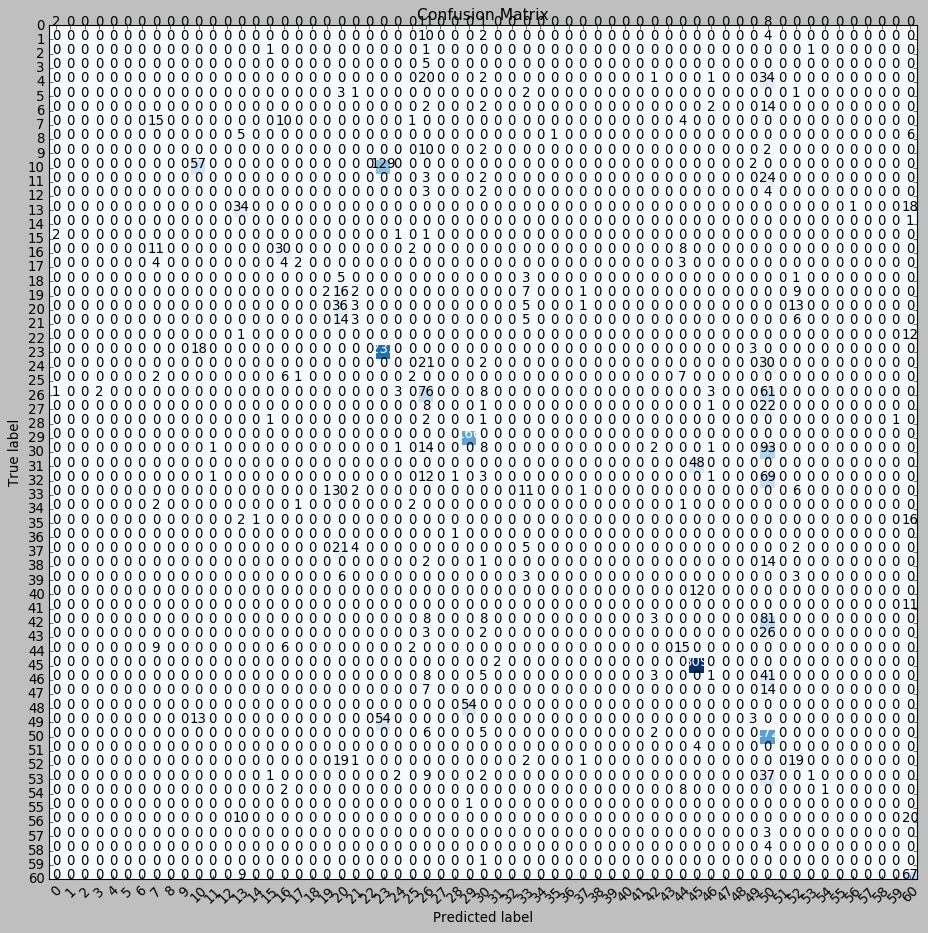

In [17]:
plt.style.use('classic')
plt.figure(figsize=(14,14))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test,normalize=False, classes= list(range(61)),title='Confusion Matrix')

## KNN

In [37]:
k = []
for K in range(4,15, 3):
        K = K+1
        start = time.time()
        k.append(K)
        model = neighbors.KNeighborsClassifier(n_neighbors = K)
        model.fit(x_train, y_train)  
        prediction_train = model.predict(x_train)
        prediction_test = model.predict(x_test)
        print(K,'time: ',(time.time()-start), accuracy_score(y_train, prediction_train),accuracy_score(y_test, prediction_test))

5 time:  28.15561056137085 0.45546629409710093 0.3997905027932961
8 time:  31.632809162139893 0.4718826405867971 0.42493016759776536
11 time:  34.161953926086426 0.4746769123297241 0.42877094972067037
14 time:  36.28907537460327 0.4853882873442776 0.4448324022346369


## ANN

#### Softmax Y for NN

In [10]:
y = np.asarray(dfk[['cause']])
encoded_y = None
for i in range(0, y.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(y[:,i])
    feature = feature.reshape(y.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    feature = onehot_encoder.fit_transform(feature)
    if encoded_y is None:
        encoded_y = feature
    else:
            encoded_y = np.concatenate((encoded_y, feature), axis=1)
print("y shape: : ", encoded_y.shape)

y shape: :  (12639, 7)


## Pivots

In [28]:
dfk = df
dfk['day'] = df.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%a'))
dfk['month'] = df.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%b'))
dfk = dfk[['cost', 'month', 'cause']]
dfk = dfk.pivot_table(index='month', columns='cause', values='cost')#.reset_index(drop=True)
#dfk['month'] = dfk.index
#dfk.reset_index(drop=True)

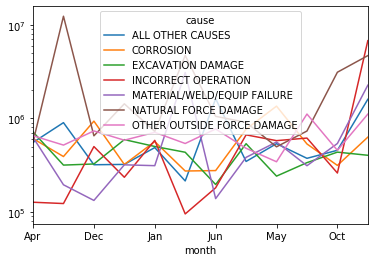

In [30]:
dfk.plot()
pyplot.yscale('log')

In [ ]:
#np.random.seed(141)
units = 10000
epochs = 3
batch_size = 64
lr = 0.00001

model = tf.keras.Sequential()
model.add(layers.Dense(units = units,input_dim = 767, activation='relu'))
model.add(layers.Dense(units = int(units), activation='relu'))
model.add(layers.Dense(units = int(units), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
#model.compile(loss = 'mse',  optimizer = "adam")
opt = SGD(lr=lr, momentum=0.9, decay=0.001)
model.compile(optimizer = opt, loss='binary_crossentropy' ,  metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = epochs, batch_size = batch_size, verbose = 1)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
prediction_train = model.predict(x_train)
prediction_test = model.predict(x_test)
#Y_train, Y_test, prediction_train, prediction_test = desoftmaxer(y_train), desoftmaxer(y_test),desoftmaxer(prediction_train), desoftmaxer(prediction_test)
print(accuracy_score(onehot_encoder.inverse_transform(y_train), onehot_encoder.inverse_transform(prediction_train)),accuracy_score(onehot_encoder.inverse_transform(y_test), onehot_encoder.inverse_transform(prediction_test)))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 10000)             7680000   
_________________________________________________________________
dense_32 (Dense)             (None, 10000)             100010000 
_________________________________________________________________
dense_33 (Dense)             (None, 10000)             100010000 
_________________________________________________________________
dense_34 (Dense)             (None, 7)                 70007     
Total params: 207,770,007
Trainable params: 207,770,007
Non-trainable params: 0
_________________________________________________________________
Train on 9479 samples, validate on 3160 samples
Epoch 1/3


In [27]:
Y_train, Y_test, Prediction_train, Prediction_test = onehot_encoder.inverse_transform(y_train), onehot_encoder.inverse_transform(y_test),onehot_encoder.inverse_transform(prediction_train), onehot_encoder.inverse_transform(prediction_test)

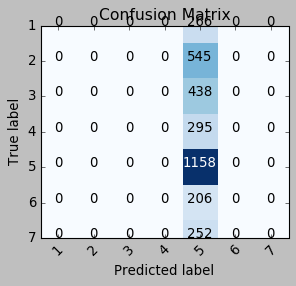

In [29]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(Y_test,Prediction_test,normalize=False, classes= ['1', '2', '3', '4', '5', '6', '7'],title='Confusion Matrix')

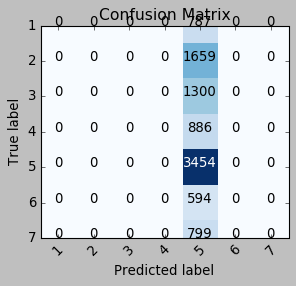

In [31]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(Y_train,Prediction_train,normalize=False, classes= ['1', '2', '3', '4', '5', '6', '7'],title='Confusion Matrix')

## Aggregates

### Aggregate by Name

In [10]:
df_g = df[['name', 'cost']].groupby(['name']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_g.columns =['name', 'mean cost', 'count', 'max cost', 'sum cost']
df_g = df_g.sort_values('count', ascending = False).reset_index(drop=True)
df_g.head()

,name,mean cost,count,max cost,sum cost
0,magellan,266905.802905,482,11637558,128648597
1,sunoco,222912.604061,394,20152935,87827566
2,enterprise crude pipeline llc,195844.842239,393,10261220,76967023
3,enterprise products operating llc,863811.586563,387,78443170,334295084
4,plains,556226.942105,380,153683744,211366238


### Cost

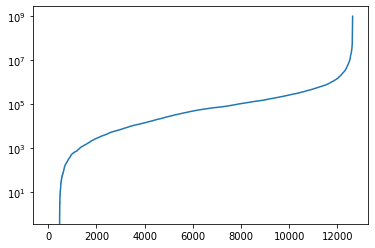

In [33]:
cost = df['cost']
cost = sorted(cost)
plt.plot(range(len(cost)), cost)
pyplot.yscale('log')


### Aggregate by Cause

In [191]:
df_g = df[['cause', 'cost']].groupby(['cause']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_g.columns =['cause', 'mean cost', 'count', 'max cost', 'sum cost']
df_g = df_g.sort_values('count', ascending = False).reset_index(drop=True)
df_g

,cause,mean cost,count,max cost,sum cost
0,MATERIAL/WELD/EQUIP FAILURE,6.947303e+05,4612,981433193,3204096160
1,CORROSION,5.612120e+05,2204,153683744,1236911186
2,EXCAVATION DAMAGE,4.100171e+05,1738,21825500,712609655
3,INCORRECT OPERATION,9.688836e+05,1181,748748658,1144251502
4,ALL OTHER CAUSES,5.915379e+05,1053,66400651,622889428
5,OTHER OUTSIDE FORCE DAMAGE,6.610029e+05,1051,55338695,694714006
6,NATURAL FORCE DAMAGE,2.961140e+06,800,598475223,2368911950


### Aggregate by SubCause

In [36]:
df_g = df[['cause_sub', 'cost']].groupby(['cause_sub']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_g.columns =['cause_sub', 'mean cost', 'count', 'max cost', 'sum cost']
df_g = df_g.sort_values('sum cost', ascending = False).reset_index(drop=True)
#plt.hist(df_g['count'], bins = 50)
#df_g['count']
df_g

,cause_sub,mean cost,count,max cost,sum cost
0,HEAVY RAINS/FLOODS,6.095538e+06,211,598475223,1286158447
1,ENVIRONMENTAL CRACKING-RELATED,1.654412e+07,73,981433193,1207721085
2,MANUFACTURING-RELATED,7.274578e+06,125,651839895,909322234
3,PIPELINE/EQUIPMENT OVERPRESSURED,1.359178e+07,57,748748658,774731550
4,EXTERNAL,8.332822e+05,821,153683744,684124714
...,...,...,...,...,...
57,VALVE,2.905600e+05,6,666573,1743360
58,COMPRESSION FITTING,1.887559e+05,8,489363,1510047
59,OTHER PIPE/WELD/JOINT FAILURE,1.155222e+05,11,220845,1270744
60,UNSPECIFIED EXCAVATION DAMAGE,3.952222e+04,23,295114,909011


## Trend in Natural Effects

In [14]:
df_sec = df.loc[df['cause'] == 'NATURAL FORCE DAMAGE']
df_sec.reset_index(drop=True, inplace=True)

In [18]:
df_sec['month'] = df_sec.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%Y-%m'))
import warnings
warnings.filterwarnings('ignore')

### Monthly

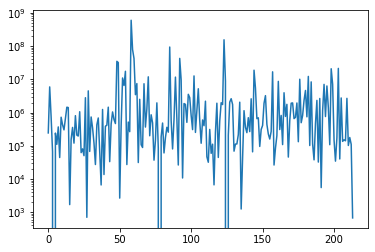

In [237]:
df_w = df_sec[['cost', 'month']].groupby(['month']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_w.columns =['week', 'cost', 'count', 'max', 'sum']
plt.plot(range(len(df_w)), df_w['max'])
pyplot.yscale('log')

### Weekly

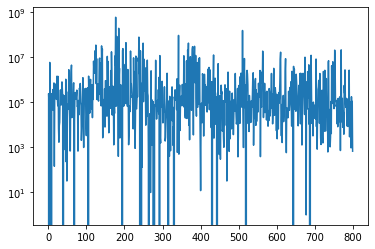

In [205]:
plt.plot(range(len(df_sec)), df_sec.cost)
pyplot.yscale('log')
plt.show()

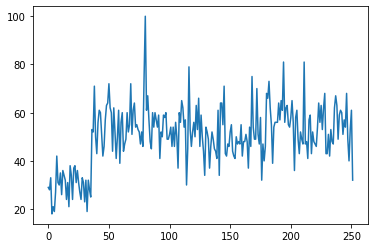

In [33]:
df_ = df
df_['month'] = df.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%Y-%m'))
df_['week'] = df.Date.apply(lambda x: (datetime.strptime(x, '%m/%d/%Y')).strftime('%Y-%W'))
df_m = df_[['cost', 'month']].groupby(['month']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_m.columns =['month', 'cost', 'count', 'max', 'sum']
plt.plot(range(len(df_m)), df_m['count'])
#pyplot.yscale('log')

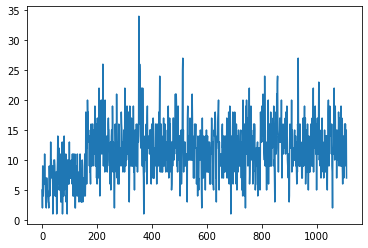

In [31]:
df_w = df_[['cost', 'week']].groupby(['week']).agg(['mean', 'count', 'max', 'sum' ]).reset_index()
df_w.columns =['week', 'cost', 'count', 'max', 'sum']
plt.plot(range(len(df_w)), df_w['count'])
#pyplot.yscale('log')

In [136]:
dfk = df
dfk = dfk[['cause_sub', 'cost', 'cause']]
#pd.DataFrame(dfk.groupby('cause')['cause_sub'].apply(list))
dfkk = pd.DataFrame(dfk.groupby('cause')['cause_sub'].apply(list)).reset_index()
len(dfkk.cause_sub[1])

2204

In [103]:
dfk = df
dfk = dfk[['cause_sub', 'cost', 'cause']]
dfk = dfk.pivot_table(index='cause_sub', columns='cause', values='cost')
dfk

cause,ALL OTHER CAUSES,CORROSION,EXCAVATION DAMAGE,INCORRECT OPERATION,MATERIAL/WELD/EQUIP FAILURE,NATURAL FORCE DAMAGE,OTHER OUTSIDE FORCE DAMAGE
cause_sub,,,,,,,
BODY OF PIPE,NaN,NaN,NaN,NaN,6.150675e+05,NaN,NaN
BUTT WELD,NaN,NaN,NaN,NaN,7.162351e+05,NaN,NaN
COMPRESSION FITTING,NaN,NaN,NaN,NaN,1.887559e+05,NaN,NaN
COMPRESSOR OR COMPRESSOR-RELATED EQUIPMENT,NaN,NaN,NaN,NaN,4.667654e+05,NaN,NaN
"CONSTRUCTION, INSTALLATION OR FABRICATION-RELATED",NaN,NaN,NaN,NaN,8.001224e+05,NaN,NaN
...,...,...,...,...,...,...,...
UNSPECIFIED OUTSIDE FORCE DAMAGE,NaN,NaN,NaN,NaN,NaN,NaN,299755.515464
UNSPECIFIED PIPE BODY OR SEAM,NaN,NaN,NaN,NaN,4.591854e+06,NaN,NaN
UNSPECIFIED WELD,NaN,NaN,NaN,NaN,4.677672e+05,NaN,NaN


In [ ]:
counties = list(df_raw['County'].unique())
matching = [s for s in counties if "VALERO" == s]
matching

In [99]:
names = (df['cause_sub'].unique()).astype(str)
#len(names) = 922
names = sorted(names)
len(names)

62

In [ ]:
names = (df['name'].unique()).astype(str)
#len(names) = 922 initial
print(len(names))
names = sorted(names)
names

## useful

In [ ]:
df = df.sort_values('mean cost', ascending = False).reset_index(drop=True)
df.rename(columns={'cost mean':'cost'})
df.columns =['name', 'mean cost', 'count', 'injury', 'count']
df = df.reset_index(drop=True) #drop drops the old index
df.reset_index(drop=True, inplace=True) #if you dont want to reassign
df = df.drop(['Cost_Reported', 'Report ID'], axis = 1)
df = df.loc[df['cause'] == 'NATURAL FORCE DAMAGE']
df['index1'] = df.index #change index to a column
pyplot.yscale('log')